# Wave Field Visualization

This notebook demonstrates how to visualize multiple iterations of a wave field from a Devito simulation.

In [14]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from plot_wave_iterations import plot_wave_iterations

## Run your simulation

First, run your simulation to generate the wave field `u_`. This should be similar to what you've already done in your `test_circle.ipynb` notebook.

Operator `initdamp` ran in 0.01 s


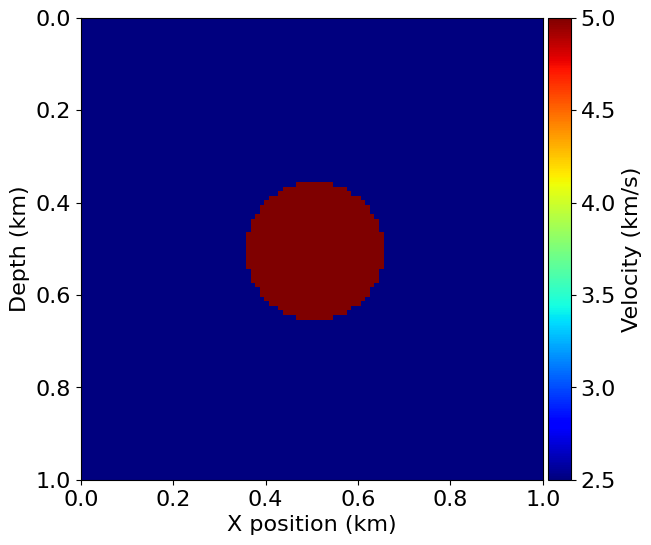

In [15]:
# Import necessary modules from Devito
from examples.seismic import demo_model, plot_velocity, plot_perturbation
from examples.seismic import AcquisitionGeometry
from examples.seismic.acoustic import AcousticWaveSolver

# Define model
shape = (101, 101)  # Number of grid points (nx, nz)
spacing = (10., 10.)  # Grid spacing in m. The domain size is now 1km by 1km
origin = (0., 0.)  # Need origin to define relative source and receiver locations

model = demo_model('circle-isotropic', vp_circle=5.0, vp_background=2.5,
                    origin=origin, shape=shape, spacing=spacing, nbl=40, radio_custom=10)

# Plot the velocity model
plot_velocity(model)

In [9]:
# Define source and receivers
t0 = 0.
tn = 1000. 
f0 = 0.01  # 10Hz

src_coordinates = np.empty((1, 2))
src_coordinates[0, :] = np.array(model.domain_size) * .5
src_coordinates[0, 1] = 0.  # Position is 20m along y-axis (horizontal)
 
nreceivers = 101  # Number of receiver locations per shot 
rec_coordinates = np.empty((nreceivers, 2))
rec_coordinates[:, 0] = np.linspace(0, model.domain_size[0], num=nreceivers)
rec_coordinates[:, 1] = 0.


# Geometry
geometry = AcquisitionGeometry(model, rec_coordinates, src_coordinates, t0, tn, f0=f0, src_type='Ricker')

In [10]:
# Run the forward simulation
solver = AcousticWaveSolver(model, geometry, space_order=4)
true_d, u_, _ = solver.forward(vp=model.vp, save=True)

# Print the shape of u_ to understand its dimensions
print(f"u_ shape: {u_.shape}")

Operator `Forward` ran in 0.02 s


u_ shape: (818, 181, 181)


## Visualize specific iterations of the wave field

Now that we have the wave field `u_`, we can visualize specific iterations.

Wave field shape: (818, 181, 181)


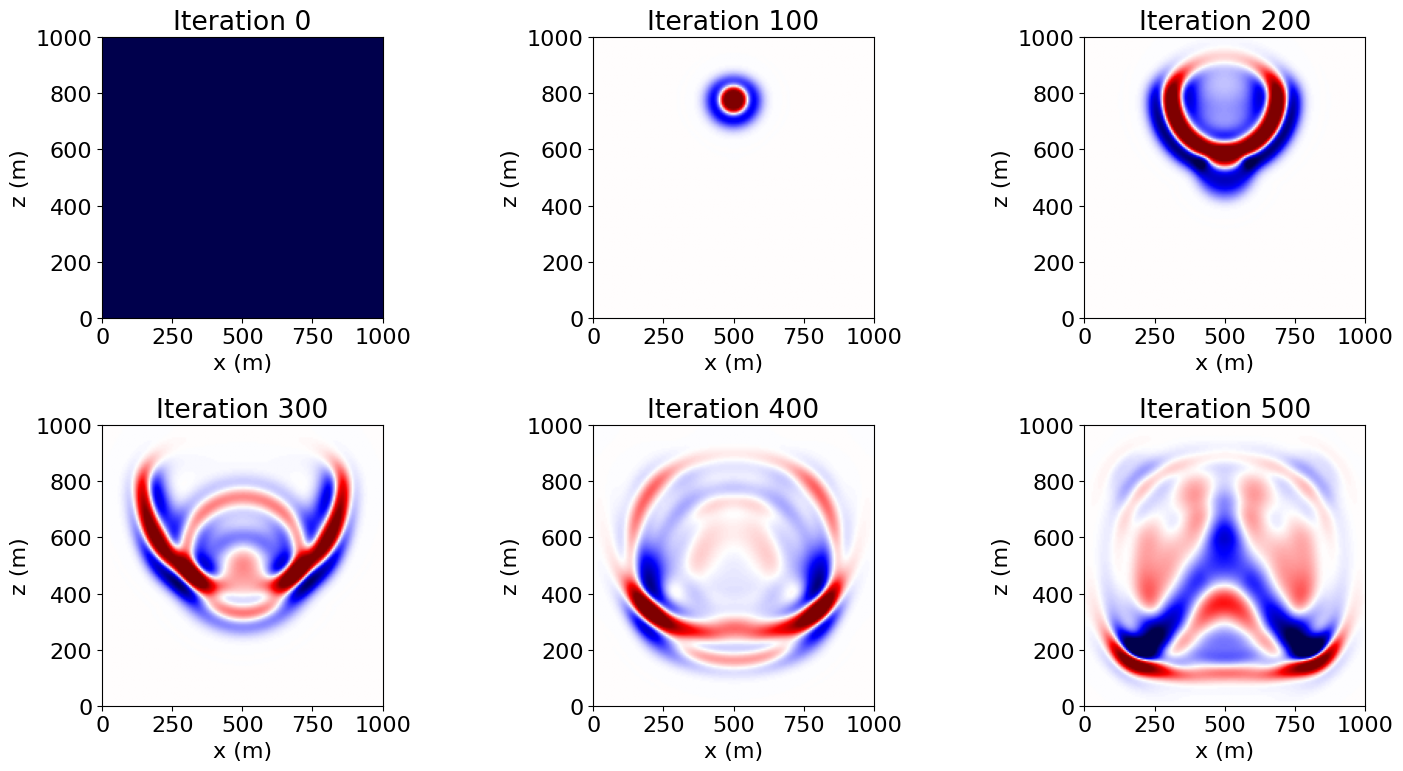

In [11]:
# Plot specific iterations of the wave field
plot_wave_iterations(u_, model, iterations=[0, 100, 200, 300, 400, 500])

## Visualize iterations at regular intervals

In [ ]:
plot_wave_iterations(u_, model, interval=20)

## Create an animation of the wave propagation

In [ ]:
# Create and save an animation
plot_wave_iterations(u_, model, interval=10, save_animation=True, filename='wave_propagation.gif')

## Custom visualization

If you need more control over the visualization, you can create your own plots using the raw data from `u_`.

## Frequency Domain Analysis

Transform the wave field to the frequency domain using Fourier transform and visualize it for several frequencies.

Frequency domain shape: (410, 181, 181)


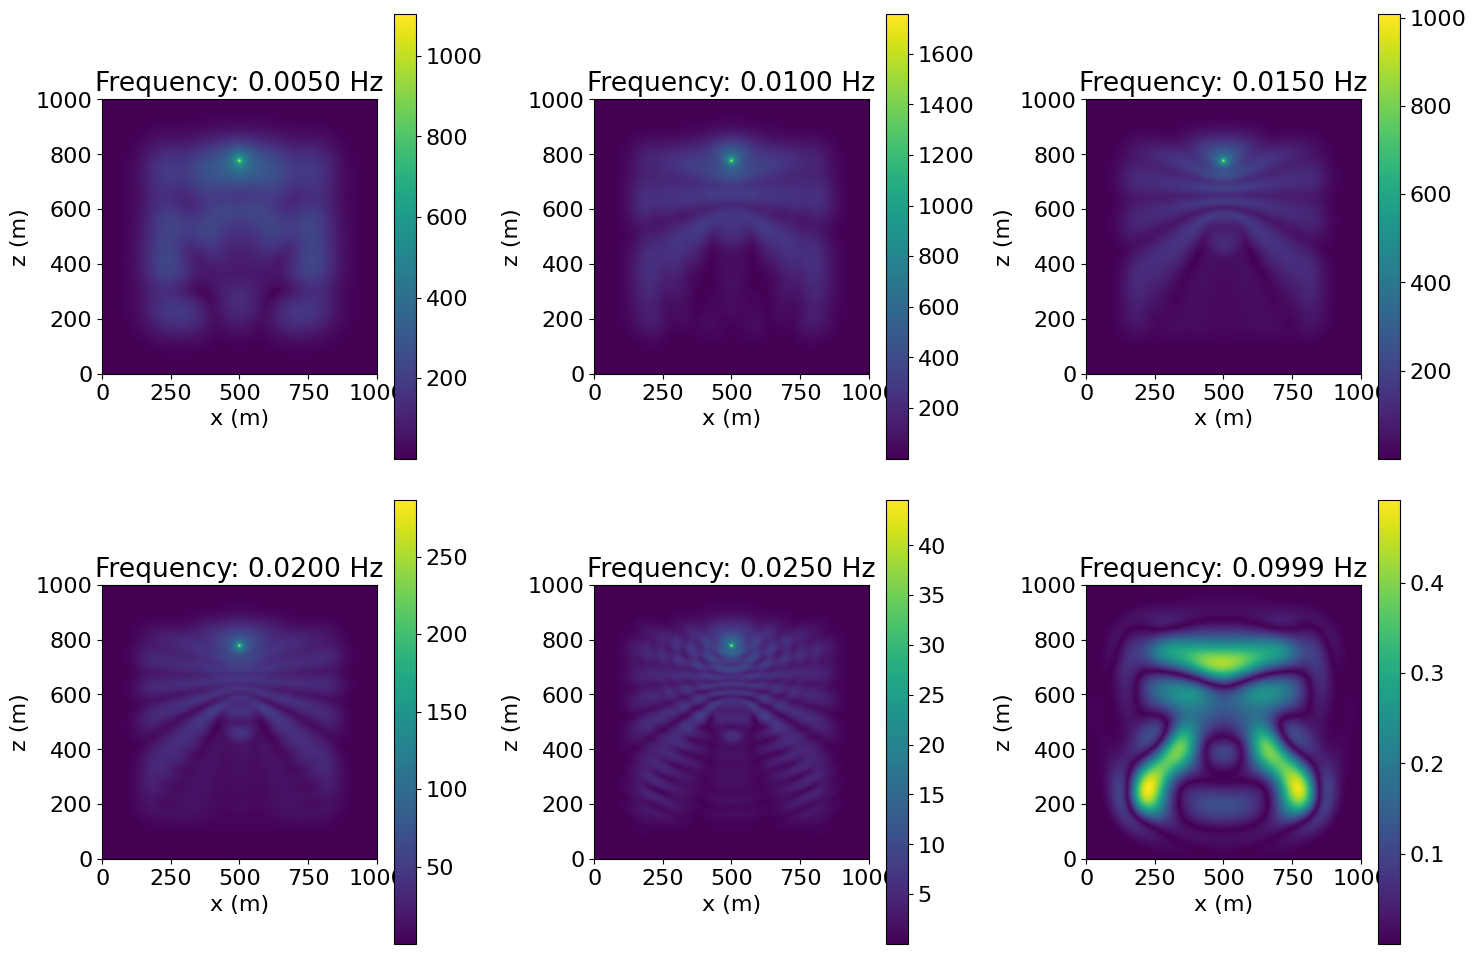

In [12]:
# Apply Fourier transform along the time dimension
u_freq = np.fft.rfft(u_.data, axis=0)
print(f"Frequency domain shape: {u_freq.shape}")

# Calculate frequency values
n_time_steps = u_.shape[0]
dt = (tn - t0) / (n_time_steps - 1)
freq = np.fft.rfftfreq(n_time_steps, d=dt)


# Select frequencies to visualize (around the source frequency f0=0.01 Hz)
target_freqs = [0.005, 0.01, 0.015, 0.02, 0.025, 0.1]
freq_indices = [np.abs(freq - f).argmin() for f in target_freqs]

# Plot magnitude of wave field at different frequencies
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, freq_idx in enumerate(freq_indices):
    magnitude = np.abs(u_freq[freq_idx])
    im = axes[i].imshow(magnitude.T, cmap='viridis',
                       extent=[model.origin[0], model.origin[0] + model.domain_size[0],
                              model.origin[1], model.origin[1] + model.domain_size[1]])
    axes[i].set_title(f'Frequency: {freq[freq_idx]:.4f} Hz')
    axes[i].set_xlabel('x (m)')
    axes[i].set_ylabel('z (m)')
    plt.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.show()

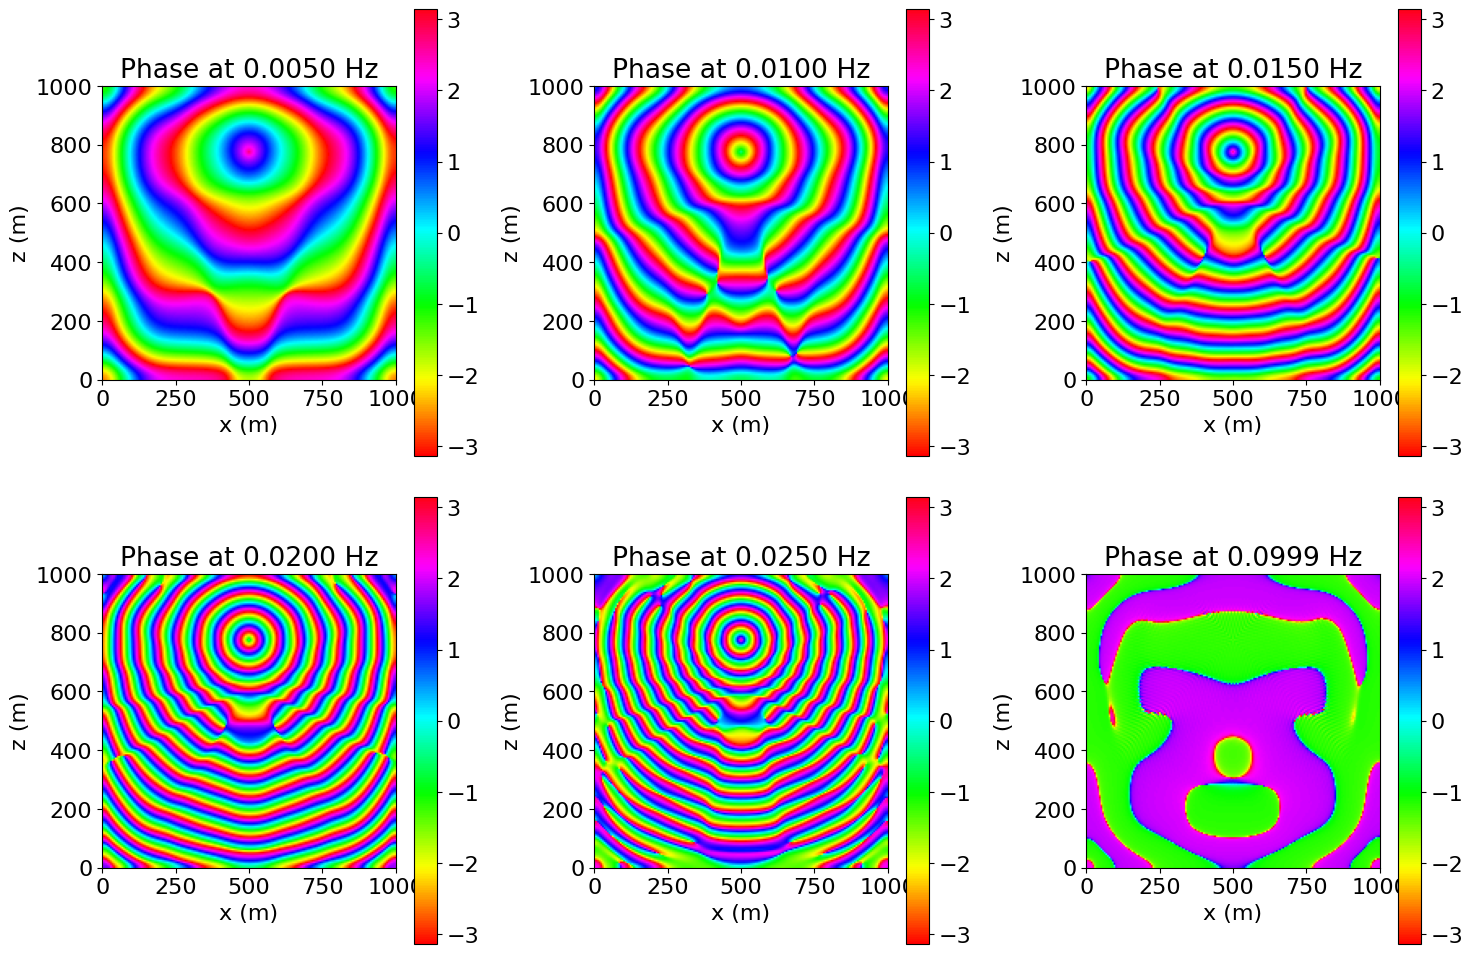

In [13]:
# Plot phase of wave field at different frequencies
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, freq_idx in enumerate(freq_indices):
    phase = np.angle(u_freq[freq_idx])
    im = axes[i].imshow(phase.T, cmap='hsv',
                       extent=[model.origin[0], model.origin[0] + model.domain_size[0],
                              model.origin[1], model.origin[1] + model.domain_size[1]],
                       vmin=-np.pi, vmax=np.pi)
    axes[i].set_title(f'Phase at {freq[freq_idx]:.4f} Hz')
    axes[i].set_xlabel('x (m)')
    axes[i].set_ylabel('z (m)')
    plt.colorbar(im, ax=axes[i])

plt.tight_layout()
plt.show()